# MODELLING

In this modelling section we will use Alzheimer's dataset which consists of mri images belonging to 4 classes;
* MildDemented
* ModerateDemented
* NonDemented
* VeryMildDemented

The images are from people who already have the Alzheimer's disease.

The dataset is split into 2 directories, one for train data and the other for test data. 

Based on the article from this [site](http://noiselab.ucsd.edu/ECE228-2020/projects/Report/52Report.pdf), it has been noted that there are some discrepancies between the test and train images from the Kaggle mri dataset. Due to this discrepancy, the models tend to perform very well on the train dataset but when it comes to evaluating the model on the test dataset, the model performs very poorly and always seems to overfit.

In order to avoid such kind of problem, we will combine the entire train and test dataset into one and convert the images into arrays. We will then shuffle the images and split them again into train, validation and test data.

## LOAD LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import pandas as pd
import tensorflow as tf
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Model, load_model
from tqdm import tqdm
from PIL import Image
import cv2
from tensorflow.keras.applications import VGG16, VGG19, DenseNet201
from tensorflow.keras.applications import EfficientNetB0
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
!pip install keras-tuner --upgrade
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import joblib

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

## Loading  Data

In [3]:
# Loading the train images
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# function to load and combine all the train images
def get_images(path = "/content/drive/MyDrive/Capstone Project/Alzheimer_s Dataset", 
               class_labels = labels):
    
    X_train = []
    y_train = []
    image_size = 150
    
    # getting the train images
    for i in class_labels:
        folderPath = os.path.join(path,'train',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_train.append(i)
    
    # getting the test images
    for i in class_labels:
        folderPath = os.path.join(path,'test',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)
            
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # shuffle all the images
    X_train, y_train = shuffle(X_train, y_train, random_state = 42)
    
    return X_train, y_train

# get images
X_train, y_train = get_images()
X_train.shape, y_train.shape

100%|██████████| 448/448 [00:06<00:00, 64.82it/s] 


((6400, 150, 150, 3), (6400,))

After combining and shuffling all the images, we will now split them into train, validation and test datasets.

In [4]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2,random_state = 42)

# splitting train data to get validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

# check shape of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((4608, 150, 150, 3),
 (4608,),
 (1280, 150, 150, 3),
 (1280,),
 (512, 150, 150, 3),
 (512,))

## Exploring the Images

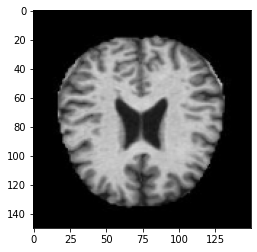

In [5]:
# preview of the first image
plt.imshow(X_train[0])

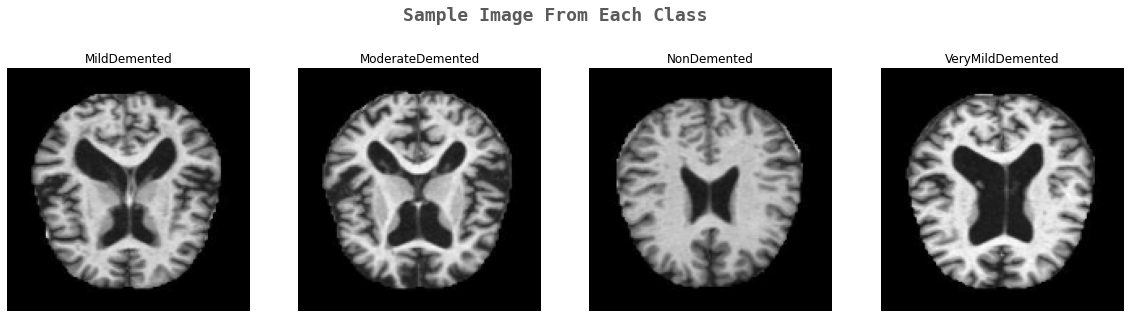

In [6]:
# preview of images from each class

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s = "Sample Image From Each Class", size = 18, fontweight = "bold",
             fontname = "monospace", color = "#313131", y = 0.62, x = 0.4, alpha = 0.8)
for i in labels:
    j = 0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

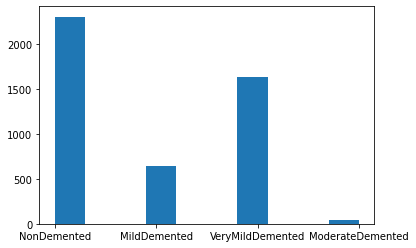

In [7]:
# view the distribution of images among classes
plt.hist(y_train);

We will now one-hot encode the labels so that the data can be used for modelling

In [8]:
# one hot encoding the train classes for modelling
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

# one hot encoding the test classes for modelling
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# one hot encoding the val classes for modelling
y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)


We will also scale all the images.

In [9]:
# scaling the train images 
def scale_images(images):
    images = images.astype('float32')
    images /= 255
    return images

X_train = scale_images(X_train)
X_val = scale_images(X_val)
X_test = scale_images(X_test)

Due to the class imbalance seen on the histogram earlier, we will use SMOTE to oversample the data so as to solve the class imbalance

In [10]:
# SMOTE to solve class imbalance
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train.reshape(-1, 150 * 150 * 3), y_train)
X_train = X_train.reshape(-1, 150, 150, 3)

# check shape of data after oversampling
X_train.shape, y_train.shape

((9204, 150, 150, 3), (9204, 4))

After using SMOTE, the number of images have increased because SMOTE creates more synthetic data which is used to solve the class imbalance.

The following are the functions that will be frequuently used during the modelling process

In [11]:
# function to evaluate model

def evaluate_model(model):
    print("train_results")
    (model.evaluate(X_train, y_train))
    print("validation_results")
    print(model.evaluate(X_val, y_val))

In [12]:
# function to plot model's performance
def plot_accuracy_loss(model):
    scores = model.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(scores["Accuracy"], label='Training accuracy')
    ax1.plot(scores["val_Accuracy"], label='Validation accuracy')
    ax1.set_title('Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')

    ax2.plot(scores["loss"], label='Training loss')
    ax2.plot(scores["val_loss"], label='Validation loss')
    ax2.set_title('Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    plt.show()

## BASELINE MODEL

For the baseline model, we will just create a simple deep learning model.

In [ ]:
def base_model():
    model = models.Sequential()
    
    # input layer
    model.add(layers.Flatten(input_shape = (150, 150, 3)))
    
    # hidden layers
    model.add(layers.Dense(4, activation = "relu"))
    model.add(layers.Dense(8, activation = "relu"))
    
    # output layer
    model.add(layers.Dense(4, activation = "softmax"))
    
    return model

base_model = base_model()

# compile model
base_model.compile(loss = "categorical_crossentropy", 
                   optimizer = "adam", 
                   metrics = ["Accuracy", "Precision", "Recall",
                             keras.metrics.AUC(name = "auc")])

# Fit the model
base_hist = base_model.fit(X_train,
                           y_train,
                           epochs = 50,
                           validation_data = (X_val, y_val))

2023-01-09 14:35:37.638146: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-09 14:35:40.355824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


Epoch 1/50
288/288 [==============================] - 4s 10ms/step - loss: 1.4564 - Accuracy: 0.2399 - precision: 0.2500 - recall: 0.0017 - auc: 0.4959 - val_loss: 1.3892 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3424
Epoch 2/50
288/288 [==============================] - 2s 8ms/step - loss: 1.3864 - Accuracy: 0.2402 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4957 - val_loss: 1.3875 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/50
288/288 [==============================] - 2s 8ms/step - loss: 1.3865 - Accuracy: 0.2448 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4965 - val_loss: 1.3870 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3424
Epoch 4/50
288/288 [==============================] - 2s 8ms/step - loss: 1.3864 - Accuracy: 0.2473 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4970 - val_loss: 1.3902 - val_Accurac

In [ ]:
evaluate_model(base_model)

train_results


2023-01-09 14:38:23.416183: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 3s 8ms/step - loss: 1.3863 - Accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
validation_results
16/16 [==============================] - 0s 7ms/step - loss: 1.3845 - Accuracy: 0.3242 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5495
[1.3845245838165283, 0.32421875, 0.0, 0.0, 0.5494791865348816]


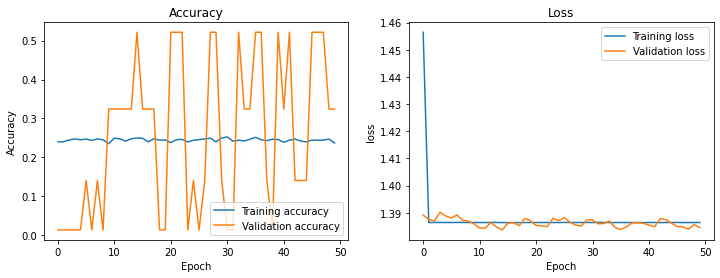

In [ ]:
plot_accuracy_loss(base_hist)

The base model has an accuracy of approximately 32% on the validation data.The model does not overfit but the accuracy is not good. The precision and recall is also not good.
We will build a Convolutional Neural Networks (CNN) model to see if the accuracy will improve.

## FIRST MODEL

In [ ]:
def model1():
    
    model = models.Sequential()

    # input layer
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))

    # adding hidden layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # output layer
    model.add(layers.Dense(4, activation='softmax'))
    
    return model

model1 = model1()

# compile the model
model1.compile(optimizer = "SGD",
                   loss = "categorical_crossentropy",
                   metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
model1_hist = model1.fit(X_train,
                           y_train,
                          steps_per_epoch = 8,
                          epochs = 30,
                          verbose = 1,
                          validation_data = (X_val, y_val)
                          )

2023-01-09 14:43:52.892795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 14:43:52.972536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 14:43:52.973456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 14:43:52.976444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2023-01-09 14:44:02.320584: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 17s 911ms/step - loss: 1.3820 - Accuracy: 0.2837 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5446 - val_loss: 1.3776 - val_Accuracy: 0.3770 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5785
Epoch 2/30
8/8 [==============================] - 4s 516ms/step - loss: 1.3558 - Accuracy: 0.3317 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6068 - val_loss: 1.2801 - val_Accuracy: 0.3203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7462
Epoch 3/30
8/8 [==============================] - 4s 532ms/step - loss: 1.3586 - Accuracy: 0.3390 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5963 - val_loss: 1.4389 - val_Accuracy: 0.0352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4274
Epoch 4/30
8/8 [==============================] - 4s 519ms/step - loss: 1.3565 - Accuracy: 0.3039 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5794 - val_loss: 1.3396 - val_Accuracy: 0.4844 -

In [ ]:
evaluate_model(model1)

train_results


2023-01-09 14:46:32.683086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.
2023-01-09 14:46:35.545461: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2485080000 exceeds 10% of free system memory.


288/288 [==============================] - 3s 10ms/step - loss: 0.7771 - Accuracy: 0.6294 - precision: 0.7525 - recall: 0.5398 - auc: 0.8897
validation_results
16/16 [==============================] - 0s 10ms/step - loss: 0.8512 - Accuracy: 0.6211 - precision: 0.7051 - recall: 0.4902 - auc: 0.8702
[0.8512243628501892, 0.62109375, 0.7050561904907227, 0.490234375, 0.8701655864715576]


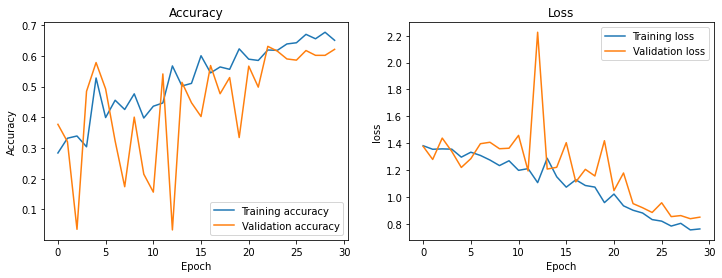

In [ ]:
plot_accuracy_loss(model1_hist)

The accuracy has increased to approximately 62%. For the next step, we will try and do data augmentation to make our model generalized to more new data. 

## Data Augmentation

In [ ]:
# Set random seed
np.random.seed(42)

# Create an ImageDataGenerator object with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range = 45, # randomly rotate images by 45 degrees
    width_shift_range = 0.2, # randomly shift images horizontally by 20%
    height_shift_range = 0.2, # randomly shift images vertically by 20%
    shear_range = 0.2, # randomly apply shearing transformations
    zoom_range = 0.2, # randomly zoom images
    horizontal_flip = True, # randomly flip images horizontally
    fill_mode="nearest" # fill in missing pixels after transformation
)

# Define the generator to augment the images
generator = datagen.flow(X_train, y_train, batch_size = 32)

# Generate augmented images and labels
X_train_aug, y_train_aug = next(generator)

# Combine the original and augmented data
X_train_combined = np.concatenate((X_train, X_train_aug))
y_train_combined = np.concatenate((y_train, y_train_aug))

X_train_combined.shape, y_train_combined.shape

((9236, 150, 150, 3), (9236, 4))

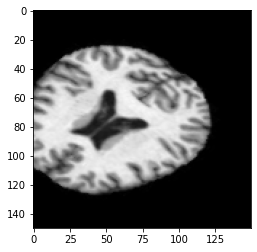

In [ ]:
# preview an image again
plt.imshow(X_train_combined[-1])

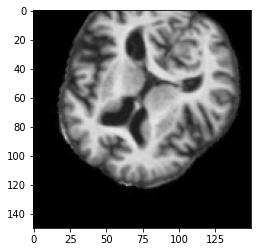

In [ ]:
# preview an image again
plt.imshow(X_train_combined[-4])

## SECOND MODEL

In [ ]:
def model2():
    
    model = models.Sequential()

    # input layer
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))

    # adding hidden layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # output layer
    model.add(layers.Dense(4, activation='softmax'))
    
    return model

model2 = model2()

# compile the model
model2.compile(optimizer = "SGD",
                   loss = "categorical_crossentropy",
                   metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
model2_hist = model2.fit(X_train_combined,
                           y_train_combined,
                          steps_per_epoch = 8,
                          epochs = 30,
                          verbose = 1,
                          validation_data = (X_val, y_val)
                          )

2023-01-09 15:03:45.058258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:03:45.175832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:03:45.176645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:03:45.179312: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2023-01-09 15:03:54.353523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 311850000 exceeds 10% of free system memory.
2023-01-09 15:03:54.353658: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 311850000 exceeds 10% of free system memory.
2023-01-09 15:03:54.656816: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 311850000 exceeds 10% of free system memory.
2023-01-09 15:03:55.779062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 18s 946ms/step - loss: 1.3805 - Accuracy: 0.2840 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5432 - val_loss: 1.2476 - val_Accuracy: 0.4824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7915
Epoch 2/30
8/8 [==============================] - 4s 531ms/step - loss: 1.3778 - Accuracy: 0.2670 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5509 - val_loss: 1.3613 - val_Accuracy: 0.2773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5938
Epoch 3/30
8/8 [==============================] - 4s 544ms/step - loss: 1.3376 - Accuracy: 0.4370 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6876 - val_loss: 1.5739 - val_Accuracy: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4823
Epoch 4/30
8/8 [==============================] - 4s 514ms/step - loss: 1.3318 - Accuracy: 0.4491 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6717 - val_loss: 1.3262 - val_Accuracy: 0.4980 -

In [ ]:
evaluate_model(model2)

train_results
288/288 [==============================] - 3s 10ms/step - loss: 0.7294 - Accuracy: 0.7118 - precision: 0.8654 - recall: 0.4535 - auc: 0.9166
validation_results
16/16 [==============================] - 0s 9ms/step - loss: 1.0013 - Accuracy: 0.5605 - precision: 0.7166 - recall: 0.2617 - auc: 0.8210
[1.0012702941894531, 0.560546875, 0.7165775299072266, 0.26171875, 0.820961594581604]


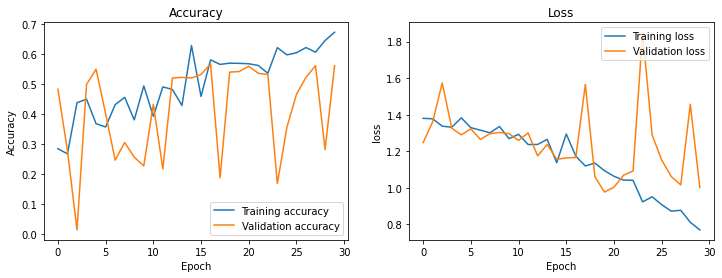

In [ ]:
plot_accuracy_loss(model2_hist)

The model's accuracy has reduced same to the precision and recall scores.
For the next model, we will do a random search using the keras tuner to get better parameters so as to improve the model's scores.

## THIRD MODEL (Random Search)

In [13]:
# function to build the model
def find_best_model(hp):
        model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int("conv_1_filter", min_value=16, max_value=32, step=16),
            kernel_size=hp.Choice("conv_1_kernel", values = [3,5]),
            activation="relu",
            input_shape=(150,150,3)
        ),
        keras.layers.Conv2D(
            filters=hp.Int("conv_2_filter", min_value=16, max_value=64, step=16),
            kernel_size=hp.Choice("conv_2_kernel", values = [3,5]),
            activation="relu"
        ),
        keras.layers.Conv2D(
            filters=hp.Int("conv_3_filter", min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice("conv_3_kernel", values = [3,5]),
            activation="relu"
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int("dense_1_units", min_value=32, max_value=128, step=16),
            activation="relu"
        ),
        keras.layers.Dense(4, activation="softmax")
      ])
        
        model.compile(optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", 
                                                                  values=[1e-2, 1e-3])),
                      loss='categorical_crossentropy',
                      metrics = ["Accuracy", "Precision", "Recall"])
        return model
    
# implement function and use random search
tuner_search = RandomSearch(find_best_model,
                            objective = "val_Accuracy",
                            max_trials = 5
                            )
tuner_search.search(X_train, y_train, epochs = 5, batch_size = 32, validation_data = (X_val, y_val))

Trial 5 Complete [00h 02m 01s]
val_Accuracy: 0.32421875

Best val_Accuracy So Far: 0.970703125
Total elapsed time: 00h 12m 38s


The best val accuracy we have gotten so far is 97% from our random search which is pretty good.

In [14]:
# view summary of the best model
model3 = tuner_search.get_best_models(num_models=1)[0]
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 32)      12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 140, 140, 80)      23120     
                                                                 
 flatten (Flatten)           (None, 1568000)           0         
                                                                 
 dense (Dense)               (None, 112)               175616112 
                                                                 
 dense_1 (Dense)             (None, 4)                 452       
                                                                 
Total params: 175,653,732
Trainable params: 175,653,732


In [22]:
# saving model and weights
model3.save("/content/drive/MyDrive/model.h5")
model3.save_weights("/content/drive/MyDrive/weights.h5")

We will now try using transfer learning models to find the best model. Since this is a medical dataset, we need to get an accuracy that is closest to 100%.

## Transfer Learning Models

Transfer learning involves the use of pre-trained models instead of training a neural network from scratch. The pretrained models serve as a starting point for training.
The transfer learning models we will use are;
* VGG16
* VGG19
* EfficientNetB0
* DenseNet

In [ ]:
# function to implement the transfer learning models.
def transfer_model(model):
    model = model(input_shape = (150, 150, 3), weights = "imagenet", include_top = False)
    
    # ensuring the model is not trained again
    for layer in model.layers:
        layer.trainable = False
        
    # adding a dense layer at the bottom 
    X = layers.Flatten()(model.output)
    X = layers.Dense(units = 4, activation = "softmax")(X)
    model = Model(model.input, X)
    
    return model

## VGG16

In [ ]:
# load vgg16 model
vgg16 = transfer_model(VGG16)

# compile model
vgg16.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
vgg16_hist = vgg16.fit(X_train,
                      y_train,
                      steps_per_epoch = 8,
                      epochs = 30,
                      verbose = 1,
                       batch_size = 32,
                      validation_data = (X_val, y_val)
                      )

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/30
8/8 [==============================] - 13s 425ms/step - loss: 1.5159 - Accuracy: 0.2734 - precision: 0.3750 - recall: 0.0820 - auc: 0.5368 - val_loss: 2.1561 - val_Accuracy: 0.1309 - val_precision: 0.1301 - val_recall: 0.0742 - val_auc: 0.3026
Epoch 2/30
8/8 [==============================] - 2s 272ms/step - loss: 1.3897 - Accuracy: 0.3945 - precision: 0.5625 - recall: 0.1055 - auc: 0.6180 - val_loss: 1.1656 - val_Accuracy: 0.3809 - val_precision: 0.2885 - val_recall: 0.0586 - val_auc: 0.7389
Epoch 3/30
8/8 [==============================] - 2s 276ms/step - loss: 1.2094 - Accuracy: 0.4336 - precision: 0.6190 - recall: 0.1016 - auc: 0.7266 - val_loss: 1.2692 - val_Accuracy: 0.4258 - val_precision: 0.7708 - val_recall: 0.0723 - val_auc: 0.6716
Epoch 4/30
8/8 [==============================] - 2s 265ms/step - loss: 1.1000 - Accuracy: 0.5273 - precision: 0.7600 - recall: 0.1484 - auc: 0.8091 - val_loss: 1.2528 - va

In [ ]:
evaluate_model(vgg16)

train_results
288/288 [==============================] - 27s 87ms/step - loss: 0.5879 - Accuracy: 0.7658 - precision: 0.8527 - recall: 0.6561 - auc: 0.9488
validation_results
16/16 [==============================] - 1s 82ms/step - loss: 0.8075 - Accuracy: 0.6406 - precision: 0.7368 - recall: 0.4648 - auc: 0.8847
[0.8075305223464966, 0.640625, 0.7368420958518982, 0.46484375, 0.8847427368164062]


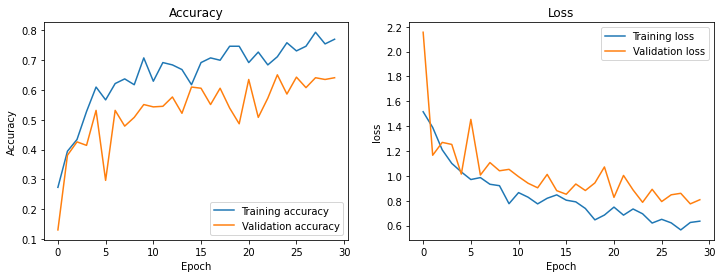

In [ ]:
plot_accuracy_loss(vgg16_hist)

## VGG19

In [ ]:
# preview summary
vgg19 = transfer_model(VGG19)
vgg19.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# compile model
vgg19.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
vgg19_hist = vgg19.fit(X_train,
                      y_train,
                      steps_per_epoch = 8,
                      epochs = 30,
                      verbose = 1,
                       batch_size = 32,
                      validation_data = (X_val, y_val)
                      )

Epoch 1/30
8/8 [==============================] - 13s 401ms/step - loss: 1.5626 - Accuracy: 0.2656 - precision: 0.3800 - recall: 0.0742 - auc: 0.5279 - val_loss: 2.2390 - val_Accuracy: 0.1367 - val_precision: 0.1699 - val_recall: 0.1035 - val_auc: 0.2822
Epoch 2/30
8/8 [==============================] - 2s 301ms/step - loss: 1.3918 - Accuracy: 0.3125 - precision: 0.3488 - recall: 0.1172 - auc: 0.6143 - val_loss: 1.1929 - val_Accuracy: 0.4590 - val_precision: 0.3649 - val_recall: 0.0527 - val_auc: 0.7538
Epoch 3/30
8/8 [==============================] - 2s 302ms/step - loss: 1.2041 - Accuracy: 0.4727 - precision: 0.6333 - recall: 0.0742 - auc: 0.7400 - val_loss: 1.2249 - val_Accuracy: 0.4668 - val_precision: 0.7528 - val_recall: 0.1309 - val_auc: 0.7080
Epoch 4/30
8/8 [==============================] - 2s 303ms/step - loss: 1.1496 - Accuracy: 0.4766 - precision: 0.7551 - recall: 0.1445 - auc: 0.7700 - val_loss: 1.4384 - val_Accuracy: 0.3066 - val_precision: 0.3913 - val_recall: 0.0176 -

In [ ]:
evaluate_model(vgg19)

train_results
288/288 [==============================] - 33s 100ms/step - loss: 0.6367 - Accuracy: 0.7337 - precision: 0.8290 - recall: 0.6109 - auc: 0.9372
validation_results
16/16 [==============================] - 2s 97ms/step - loss: 0.8381 - Accuracy: 0.6211 - precision: 0.7212 - recall: 0.4648 - auc: 0.8743
[0.8381149768829346, 0.62109375, 0.7212121486663818, 0.46484375, 0.8742784261703491]


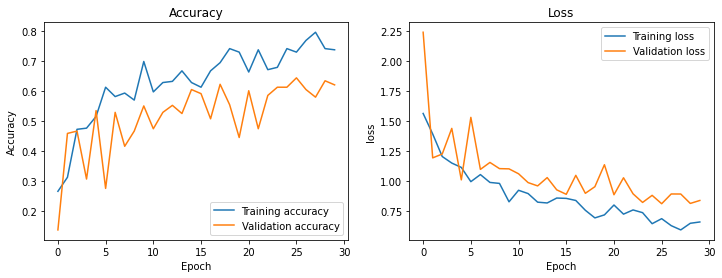

In [ ]:
plot_accuracy_loss(vgg19_hist)

## EfficientNetB0

In [ ]:
# preview summary
efficientnet = transfer_model(EfficientNetB0)
efficientnet.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

In [ ]:
# compile model
efficientnet.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
efficientnet_hist = efficientnet.fit(X_train,
                                      y_train,
                                      steps_per_epoch = 8,
                                      epochs = 30,
                                      verbose = 1,
                                      batch_size = 32,
                                      validation_data = (X_val, y_val)
                                      )

Epoch 1/30
8/8 [==============================] - 16s 415ms/step - loss: 4.5864 - Accuracy: 0.2227 - precision: 0.2565 - recall: 0.1914 - auc: 0.4538 - val_loss: 4.1985 - val_Accuracy: 0.1406 - val_precision: 0.1406 - val_recall: 0.1406 - val_auc: 0.2578
Epoch 2/30
8/8 [==============================] - 1s 118ms/step - loss: 2.9964 - Accuracy: 0.2305 - precision: 0.2258 - recall: 0.1914 - auc: 0.4715 - val_loss: 3.6908 - val_Accuracy: 0.3242 - val_precision: 0.3242 - val_recall: 0.3242 - val_auc: 0.4225
Epoch 3/30
8/8 [==============================] - 1s 118ms/step - loss: 2.1910 - Accuracy: 0.2539 - precision: 0.2635 - recall: 0.1523 - auc: 0.4905 - val_loss: 2.1762 - val_Accuracy: 0.3242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4225
Epoch 4/30
8/8 [==============================] - 1s 119ms/step - loss: 1.7794 - Accuracy: 0.2227 - precision: 0.2544 - recall: 0.1680 - auc: 0.5063 - val_loss: 1.4724 - val_Accuracy: 0.1406 - val_precision: 0.0000e+00 - val_reca

In [ ]:
evaluate_model(efficientnet)

train_results
288/288 [==============================] - 13s 40ms/step - loss: 1.7173 - Accuracy: 0.2500 - precision: 0.2500 - recall: 0.2500 - auc: 0.5020
validation_results
16/16 [==============================] - 1s 40ms/step - loss: 1.8016 - Accuracy: 0.3242 - precision: 0.3242 - recall: 0.3242 - auc: 0.4242
[1.801601767539978, 0.32421875, 0.32421875, 0.32421875, 0.42416447401046753]


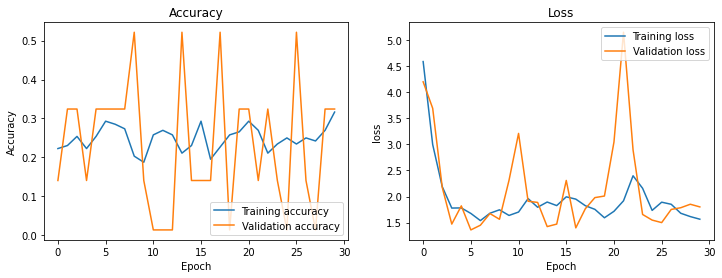

In [ ]:
plot_accuracy_loss(efficientnet_hist)

## DENSENET201

In [ ]:
# preview summary
densenet = transfer_model(DenseNet201)
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
# compile model
densenet.compile(optimizer = "adam",
               loss = "categorical_crossentropy",
               metrics = ["Accuracy", "Precision", "Recall", keras.metrics.AUC(name = "auc")])

# fit model
densenet_hist = densenet.fit(X_train,
                          y_train,
                          steps_per_epoch = 8,
                          epochs = 30,
                          verbose = 1,
                          batch_size = 32,
                          validation_data = (X_val, y_val)
                          )

Epoch 1/30
8/8 [==============================] - 25s 743ms/step - loss: 9.0564 - Accuracy: 0.2344 - precision: 0.2379 - recall: 0.2305 - auc: 0.4914 - val_loss: 3.5850 - val_Accuracy: 0.5215 - val_precision: 0.5215 - val_recall: 0.5215 - val_auc: 0.7111
Epoch 2/30
8/8 [==============================] - 2s 255ms/step - loss: 5.3529 - Accuracy: 0.3203 - precision: 0.3147 - recall: 0.3086 - auc: 0.5622 - val_loss: 6.4127 - val_Accuracy: 0.1641 - val_precision: 0.1659 - val_recall: 0.1426 - val_auc: 0.3430
Epoch 3/30
8/8 [==============================] - 2s 268ms/step - loss: 3.0447 - Accuracy: 0.3750 - precision: 0.3708 - recall: 0.3477 - auc: 0.6575 - val_loss: 1.6371 - val_Accuracy: 0.4902 - val_precision: 0.5000 - val_recall: 0.4688 - val_auc: 0.7784
Epoch 4/30
8/8 [==============================] - 2s 258ms/step - loss: 1.9098 - Accuracy: 0.5352 - precision: 0.5447 - recall: 0.5234 - auc: 0.7684 - val_loss: 1.8023 - val_Accuracy: 0.5078 - val_precision: 0.5165 - val_recall: 0.4902 -

In [ ]:
evaluate_model(densenet)

train_results
288/288 [==============================] - 29s 90ms/step - loss: 0.4847 - Accuracy: 0.8113 - precision: 0.8209 - recall: 0.8030 - auc: 0.9616
validation_results
16/16 [==============================] - 1s 82ms/step - loss: 0.9348 - Accuracy: 0.6270 - precision: 0.6351 - recall: 0.6152 - auc: 0.8814
[0.9347749352455139, 0.626953125, 0.6350806355476379, 0.615234375, 0.8813959956169128]


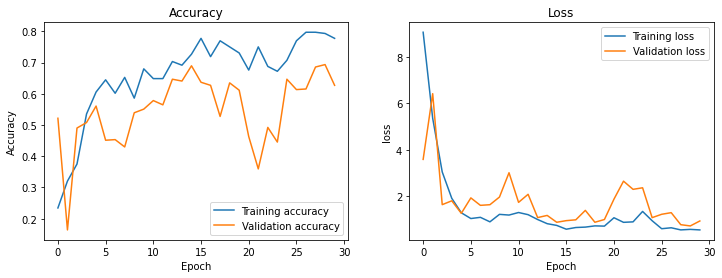

In [ ]:
plot_accuracy_loss(densenet_hist)

From the above models, the best model we've gotten so far is the model from the random search with a validation accuracy of 97%.
The best transfer learning model is the VGG16 but the accuracy is still not good since this is a medical dataset which requires an accuracy of 90% and above.
We will test our best model on the test dataset and see how it performs.

# EVALUATION

In [3]:
# Load the model
best_model = tf.keras.models.load_model("model.h5")

# Load the model's weights
best_model.load_weights("weights.h5")

In [17]:
# evaluating the model on the test data
best_model.evaluate(X_test, y_test)

40/40 [==============================] - 2s 35ms/step - loss: 0.1565 - Accuracy: 0.9563 - precision: 0.9562 - recall: 0.9555


[0.15653595328330994,
 0.956250011920929,
 0.9562157988548279,
 0.9554687738418579]

The model achieves an accuracy of 96.5% on the test dataset which is very good. This shows that the model does not overfit and it also performs well on unseen data.
This is the model that will be used for deployment.

In [18]:
# making predictions using the model
pred = best_model.predict(X_test)
pred = np.argmax(pred, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

# print the classification report
print(classification_report(y_test_new, pred))

40/40 [==============================] - 1s 32ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       187
           1       1.00      0.74      0.85        19
           2       0.94      0.99      0.96       632
           3       0.98      0.91      0.94       442

    accuracy                           0.96      1280
   macro avg       0.97      0.90      0.93      1280
weighted avg       0.96      0.96      0.96      1280



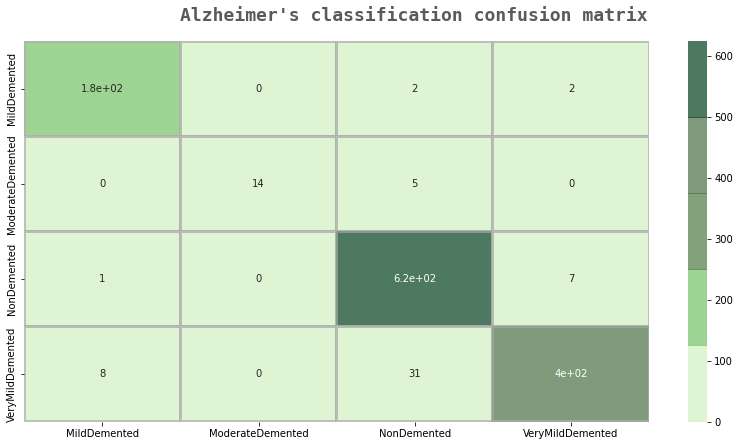

In [19]:
# colors for the confusion matrix
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

# plotting the confusion matrix
fig, ax = plt.subplots(1, 1, figsize =  (14, 7))

sns.heatmap(confusion_matrix(y_test_new, pred), ax = ax, xticklabels = labels, yticklabels = labels, annot = True,
           cmap = colors_green[::-1], alpha = 0.7, linewidths = 2, linecolor = colors_dark[3])

fig.text(s = "Alzheimer's classification confusion matrix", size = 18, fontweight = "bold",
             fontname = "monospace", color = colors_dark[1], y = 0.92, x = 0.28, alpha = 0.8)

plt.show()

The following code shows the various CNN models we had and their scores

In [20]:
column_names = ["Accuracy", "Precision", "Recall"]

row1 = [0.3242, 0.0, 0.0]
row2 = [0.6210, 0.7050, 0.4902]
row3 = [0.5605, 0.7165, 0.2617]
row4 = [0.9563, 0.9562, 0.9555]

df = pd.DataFrame([row1, row2, row3, row4], columns = column_names)

df.index = ["Base_model", "model1(CNN)", "model2(Augmentation)", "model3(RandomSearch)"]

df

,Accuracy,Precision,Recall
Base_model,0.3242,0.0000,0.0000
model1(CNN),0.6210,0.7050,0.4902
model2(Augmentation),0.5605,0.7165,0.2617
model3(RandomSearch),0.9563,0.9562,0.9555


The following code shows the transfer learning models we used and their scores.

In [21]:
column_names = ["Accuracy", "Precision", "Recall", "AUC"]

row1 = [0.6406, 0.7368, 0.4648, 0.8847]
row2 = [0.6210, 0.7212, 0.4648, 0.8742]
row3 = [0.3242, 0.3242, 0.3242, 0.4241]
row4 = [0.6269, 0.6350, 0.6152, 0.8813]

df2 = pd.DataFrame([row1, row2, row3, row4], columns = column_names)

df2.index = ["VGG16", "VGG19", "EfficientNetB0", "DenseNet201"]

df2

,Accuracy,Precision,Recall,AUC
VGG16,0.6406,0.7368,0.4648,0.8847
VGG19,0.6210,0.7212,0.4648,0.8742
EfficientNetB0,0.3242,0.3242,0.3242,0.4241
DenseNet201,0.6269,0.6350,0.6152,0.8813
